In [1]:
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
  preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = './data/train'
valid_path = './data/test'
train_image_files = glob(train_path +'/*/*.jpg')
valid_image_files = glob(valid_path +'/*/*.jpg')

In [2]:
folders = glob(train_path + '/*')
print(folders)

['./data/train\\melanoma', './data/train\\no_melanoma']


In [3]:
IMAGE_SIZE = [150, 150]
#Se crea un Image Generator 
gen = ImageDataGenerator()

In [4]:
#Generador para el conjunto de entrenamiento
batch_size = 32

train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode = 'binary'
)
# Generador para el conjunto de validación
valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode = 'binary'
)

Found 6916 images belonging to 2 classes.
Found 1729 images belonging to 2 classes.


In [5]:
from tensorflow.keras.layers import Activation, Convolution2D, Dropout, Conv2D
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

In [6]:
#Modeo mi-Xception extraido de (https://github.com/oarriaga/face_classification/tree/master/src/models)
def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
               # kernel_regularizer=regularization,
               padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('sigmoid', name='predictions')(x)

    model = Model(img_input, output)
    return model

In [7]:
#Instancia del modelo 1: mini_XCEPTION
miniXception = mini_XCEPTION(input_shape=(150,150,3), num_classes=1)
miniXception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 148, 148, 8)  216         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 148, 148, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 148, 148, 8)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]


#Callabacks
patience = 10
early_stop = EarlyStopping('val_loss',patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss',factor=0.1, patience=int(patience/4), verbose=1)
callbacks = [early_stop, reduce_lr]

miniXception.compile(optimizer='adam', 
                     loss='binary_crossentropy', 
                     metrics=METRICS)

In [9]:
log_r = miniXception.fit(train_generator,
                         batch_size=32,
                         epochs=20, 
                         verbose=1,
                         validation_data=valid_generator)

Epoch 1/20
217/217 [==============================] - 129s 557ms/step - loss: 0.6559 - tp: 2529.0000 - fp: 830.0000 - tn: 2442.0000 - fn: 1115.0000 - accuracy: 0.7188 - precision: 0.7529 - recall: 0.6940 - auc: 0.7821 - val_loss: 0.7938 - val_tp: 898.0000 - val_fp: 768.0000 - val_tn: 50.0000 - val_fn: 13.0000 - val_accuracy: 0.5483 - val_precision: 0.5390 - val_recall: 0.9857 - val_auc: 0.6377
Epoch 2/20
217/217 [==============================] - 121s 555ms/step - loss: 0.5528 - tp: 2731.0000 - fp: 690.0000 - tn: 2582.0000 - fn: 913.0000 - accuracy: 0.7682 - precision: 0.7983 - recall: 0.7495 - auc: 0.8446 - val_loss: 0.6499 - val_tp: 856.0000 - val_fp: 599.0000 - val_tn: 219.0000 - val_fn: 55.0000 - val_accuracy: 0.6217 - val_precision: 0.5883 - val_recall: 0.9396 - val_auc: 0.8324
Epoch 3/20
217/217 [==============================] - 122s 560ms/step - loss: 0.5075 - tp: 2797.0000 - fp: 680.0000 - tn: 2592.0000 - fn: 847.0000 - accuracy: 0.7792 - precision: 0.8044 - recall: 0.7676 - a

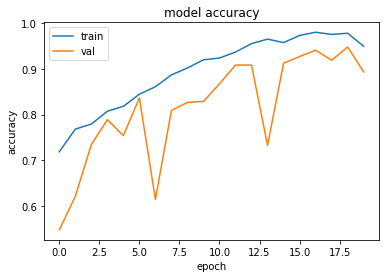

In [10]:
from matplotlib import pyplot as plt

plt.plot(log_r.history['accuracy'])
plt.plot(log_r.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
miniXception.save('minixception_150x150.h5')

C:\Users\MSI\Anaconda3\envs\env_tesis\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [12]:
miniXception.save_weights('minixception_150x150')

In [21]:
test = pd.read_csv('sample.csv')
test['ID']=test['ID']+'.jpg'
test.head()

,ID,riesgo
0,c890196d33d6b569680c6f089bc83b95.jpg,0.5
1,93ead62bbb22ed4ef466d308fd32476e.jpg,0.5
2,752ba789481175a51f5f986edae665ac.jpg,0.5
3,d6428bef7cf365baaeab1584f65ac80b.jpg,0.5
4,baf3e9e642184e461cf9f7f5b9c0d06e.jpg,0.5


In [29]:

path = './test/test/'
import cv2
prob = []
for file in list(test['ID']):
    img = cv2.imread(path+file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    res = cv2.resize(img, dsize=(150,150))
    x = image.img_to_array(res)
    x = np.expand_dims(x, axis=0)
    
    feat = miniXception.predict(x)
    prob.append(feat[0][0])
    

In [30]:
test_2 = pd.read_csv('sample.csv')
test_2['riesgo'] = prob
test_2.tail(5)

,ID,riesgo
9933,a2ad05042cc442972546c81ebf564d17,0.995464
9934,1cfc9c0844fc8c39c6db211fb57a4b00,1.000000
9935,4e4deb3e76c2f32011f0c54a83864571,1.000000
9936,d4d51aaef0b34007705be379219f56f3,1.000000
9937,48ca1384ceab3f5261dedf80196cef9b,0.999977


In [34]:
test_2['riesgo']=1-test_2['riesgo']

In [35]:
test_2.to_csv('test.csv', index=False)